In [ ]:
!pip install -q rlcard torch numpy matplotlib seaborn scipy pandas eval7

import rlcard
import torch
import numpy as np
import matplotlib.pyplot as plt

print("✓ All dependencies installed successfully!")
print(f"\\nRLCard version: {rlcard.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("🚀 Training will use GPU acceleration!")
else:
    print("⚠️ No GPU detected. Training will use CPU (slower).")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.3/675.3 kB 25.1 MB/s eta 0:00:00
✓ All dependencies installed successfully!
\nRLCard version: 1.2.0
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
🚀 Training will use GPU acceleration!


In [ ]:
import numpy as np
import random
import eval7

class OddsAgentV21(object):
    '''GTO-inspired poker agent using equity calculations and pot odds.'''

    def __init__(self, num_actions, threshold_offset=None):
        if threshold_offset is None:
            threshold_offset = {'preflop': 0, 'flop': 0, 'turn': 0, 'river': 0}

        self.use_raw = True
        self.num_actions = num_actions

        # Pre-calculated hand strength rankings
        self.preflop_value_dict = {
             '32o': 0.0, '42o': 0.006, '52o': 0.012, '62o': 0.018, '72o': 0.024,
             '32s': 0.030, '43o': 0.036, '63o': 0.042, '42s': 0.048, '53o': 0.054,
             '62s': 0.060, '73o': 0.065, '82o': 0.071, '72s': 0.077, '52s': 0.083,
             '54o': 0.089, '43s': 0.095, '83o': 0.101, '64o': 0.107, '74o': 0.113,
             '53s': 0.119, '63s': 0.125, '92o': 0.131, '84o': 0.137, '82s': 0.143,
             '65o': 0.149, '73s': 0.155, '83s': 0.161, '93o': 0.167, '75o': 0.173,
             '54s': 0.179, '94o': 0.185, '64s': 0.190, 'T2o': 0.196, '85o': 0.202,
             '74s': 0.208, '76o': 0.214, '84s': 0.220, '92s': 0.226, 'T3o': 0.232,
             '95o': 0.238, '65s': 0.244, '94s': 0.250, '93s': 0.256, 'T4o': 0.262,
             '86o': 0.268, '75s': 0.274, '76s': 0.280, '96o': 0.286, 'T3s': 0.292,
             'T2s': 0.298, '86s': 0.304, '87o': 0.310, 'T5o': 0.315, '85s': 0.321,
             '95s': 0.327, 'J2o': 0.333, 'J3o': 0.339, 'J2s': 0.345, '97o': 0.351,
             'T4s': 0.357, 'J4o': 0.363, '22': 0.369, 'T6o': 0.375, '96s': 0.381,
             'Q2o': 0.387, 'J5o': 0.393, 'J6o': 0.399, '98o': 0.405, '87s': 0.411,
             'Q3o': 0.417, 'T7o': 0.423, 'T6s': 0.429, 'J4s': 0.435, 'J3s': 0.440,
             'T5s': 0.446, '97s': 0.452, 'J5s': 0.458, 'Q4o': 0.464, 'Q5o': 0.470,
             'T8o': 0.476, 'J7o': 0.482, '33': 0.488, 'Q2s': 0.494, 'K2o': 0.500,
             'Q3s': 0.506, 'J6s': 0.512, '98s': 0.518, 'T7s': 0.524, 'Q6o': 0.530,
             'K3o': 0.536, 'T9o': 0.542, 'J8o': 0.548, 'T8s': 0.554, 'Q7o': 0.560,
             'Q5s': 0.565, 'Q4s': 0.571, 'J7s': 0.577, 'Q6s': 0.583, 'K2s': 0.589,
             'K4o': 0.595, 'T9s': 0.601, '44': 0.607, 'K3s': 0.613, 'J9o': 0.619,
             'K5o': 0.625, 'Q8o': 0.631, 'Q7s': 0.637, 'J8s': 0.643, 'K4s': 0.649,
             'K6o': 0.655, 'A2o': 0.661, 'Q8s': 0.667, 'K5s': 0.673, 'JTo': 0.679,
             'J9s': 0.685, 'K7o': 0.690, 'Q9o': 0.696, 'A3o': 0.702, 'K6s': 0.708,
             'A2s': 0.714, 'K8o': 0.720, '55': 0.726, 'JTs': 0.732, 'A4o': 0.738,
             'QTo': 0.744, 'K7s': 0.750, 'Q9s': 0.756, 'K8s': 0.762, 'A3s': 0.768,
             'QJo': 0.774, 'A6o': 0.780, 'A5o': 0.786, 'K9o': 0.792, 'A4s': 0.798,
             'A7o': 0.804, 'QTs': 0.810, 'A6s': 0.815, '66': 0.821, 'K9s': 0.827,
             'A5s': 0.833, 'KTo': 0.839, 'QJs': 0.845, 'A8o': 0.851, 'KJo': 0.857,
             'A9o': 0.863, 'A8s': 0.869, 'KTs': 0.875, '77': 0.881, 'KQo': 0.887,
             'A7s': 0.893, 'KJs': 0.899, 'A9s': 0.905, 'ATo': 0.911, 'AJo': 0.917,
             'KQs': 0.923, 'ATs': 0.929, 'AQo': 0.935, 'AJs': 0.940, '88': 0.946,
             'AKo': 0.952, 'AQs': 0.958, '99': 0.964, 'AKs': 0.970, 'TT': 0.976,
             'JJ': 0.982, 'QQ': 0.988, 'KK': 0.994, 'AA': 1.0
        }

        # Parameters by game stage
        base_params = {
            'threshold_re_rasise': 0.80, 'threshold_open_raise': 0.70,
            'threshold_call': 0.60, 'threshold_re_raise_add': 0.05,
            'pct_raise_mix_call': 0.30, 'pct_raise_mix_check': 0.10,
            'pct_call_mix_raise': 0.25, 'pct_call_mix_fold': 0.15,
            'pct_fold_mix_call': 0.05, 'pct_fold_mix_raise': 0.10,
            'pct_check_mix_raise': 0.10, 'pct_equity_enough_raise': 0.4
        }

        self.para_all = {}
        for stage, offset in threshold_offset.items():
            params = base_params.copy()
            params['threshold_re_rasise'] += offset
            params['threshold_open_raise'] += offset
            params['threshold_call'] += offset
            self.para_all[stage] = params

        # Poker ranges
        self.range_full = eval7.HandRange("A2+, K2+, Q2+, J2+, T2+, 92+, 82+, 72+, 62+, 52+, 42+, 32+, 22+")
        self.range_50 = eval7.HandRange("22+, A2s+, K2s+, Q7s+, J7s+, T7s+, 96s+, 86s+, 75s+, 64s+, 53s+, 43s, A2o+, K5o+, Q8o+, J8o+, T8o+, 98o, 87o, 76o, 65o")
        self.range_35 = eval7.HandRange("22+, A2s+, K8s+, Q8s+, J8s+, T7s+, 97s+, 86s+, 75s+, 64s+, 54s, 43s, A8o+, A5o-A2o, K9o+, Q9o+, J9o+, T9o")

    def step_generic_para(self, state, step_no):
        step_name = {0: 'preflop', 1: 'flop', 2: 'turn', 3: 'river'}[step_no]
        para_step = self.para_all[step_name]

        # Hand strength
        h1, h2 = state['raw_obs']['hand']
        hand_169 = h1[1]+h2[1] if h1[1]==h2[1] else h1[1]+h2[1]+('s' if h1[0]==h2[0] else 'o')
        my_strength = self.preflop_value_dict.get(hand_169, 0)

        # Equity calculation post-flop
        if step_no >= 1:
            cards_hand = [eval7.Card(x[1]+x[0].lower()) for x in state['raw_obs']['hand']]
            cards_public = [eval7.Card(x[1]+x[0].lower()) for x in state['raw_obs']['public_cards']]
            range_use = [self.range_full, self.range_50, self.range_35][min(step_no-1, 2)]
            my_equity = eval7.py_hand_vs_range_exact(cards_hand, range_use, cards_public)
        else:
            my_equity = 0.45

        decision_value = my_strength if step_no == 0 else my_equity

        # Decision logic
        if 'check' in state['raw_legal_actions']:
            if random.uniform(0, 1) < decision_value:
                return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
            else:
                if random.uniform(0, 1) < para_step['pct_check_mix_raise']:
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'check'
                return 'check'
        else:
            port_size = sum(state['raw_obs']['all_chips'])
            bet_amt = max(x - state['raw_obs']['my_chips'] for x in state['raw_obs']['all_chips'] if x != state['raw_obs']['my_chips'])
            bet_amt_pct = bet_amt/port_size if port_size > 0 else 0

            if decision_value > bet_amt_pct:
                if random.uniform(0, 1) < decision_value:
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
                return 'call'
            else:
                if random.uniform(0, 1) < para_step['pct_fold_mix_call']:
                    return 'call'
                elif random.uniform(0, 1) < para_step['pct_fold_mix_raise']/(1-para_step['pct_fold_mix_call']):
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
                return 'fold'

    def step(self, state):
        num_cards = len(state['raw_obs']['public_cards'])
        return self.step_generic_para(state, [0, 1, 2, 3][min(num_cards//3 + (1 if num_cards==4 else 0), 3)])

    def eval_step(self, state):
        probs = [0] * self.num_actions
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])
        info = {'probs': {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]]
                         for i in range(len(state['legal_actions']))}}
        return self.step(state), info

print("✓ OddsAgentV21 class defined")

✓ OddsAgentV21 class defined


TRAINING POKER BOT WITH NFSP
\nEnvironment: Limit Hold'em (2 players)
Training episodes: 5000
State shape: [[72], [72]]
--> Running on the GPU
Training on: cuda:0
\n Trainable: NFSP
  Benchmark: OddsAgentV21
\n================================================================================
STARTING TRAINING
================================================================================\n

----------------------------------------
  episode      |  5993
  reward       |  -0.716
----------------------------------------
Episode    0/5000 | Performance: -0.7160

----------------------------------------
  episode      |  12016
  reward       |  -0.8145
----------------------------------------
Episode   50/5000 | Performance: -0.8145
INFO - Step 100, rl-loss: 1.0954933166503906
INFO - Copied model parameters to target network.
INFO - Step 182, rl-loss: 10.46058177947998
----------------------------------------
  episode      |  18451
  reward       |  -0.5755
--------------------------------

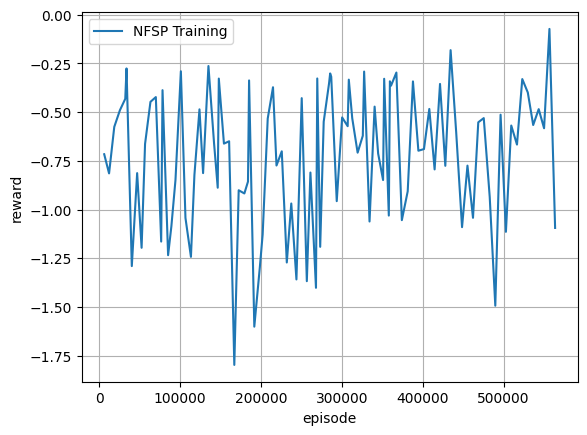

In [ ]:
import rlcard
from rlcard.agents import NFSPAgent, RandomAgent
from rlcard.utils import tournament, reorganize, Logger, plot_curve, get_device
import os

print("="*80)
print("TRAINING POKER BOT WITH NFSP")
print("="*80)

# Configuration
EPOCHS = 5000  # Can reduce to 2000 for faster testing
EVAL_EVERY = 50
EVAL_GAMES = 1000

# Setup environment
env = rlcard.make('limit-holdem', config={
    'seed': 42,
    'allow_step_back': True,
    'game_num_players': 2
})

print(f"\\nEnvironment: Limit Hold'em (2 players)")
print(f"Training episodes: {EPOCHS}")
print(f"State shape: {env.state_shape}")

# Get device
device = get_device()
print(f"Training on: {device}")

# Initialize agents
agent = NFSPAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    hidden_layers_sizes=[64, 64],
    q_mlp_layers=[64, 64],
    device=device,
    evaluate_with='best_response'
)

agent_bench = OddsAgentV21(num_actions=env.num_actions)
env.set_agents([agent, agent_bench])

print(f"\\n Trainable: NFSP")
print(f"  Benchmark: OddsAgentV21")

# Training
log_dir = './experiments/colab_results/'
os.makedirs(log_dir, exist_ok=True)

print(f"\\n{'='*80}")
print("STARTING TRAINING")
print(f"{'='*80}\\n")

with Logger(log_dir) as logger:
    for episode in range(EPOCHS):
        trajectories, payoffs = env.run(is_training=True)
        trajectories = reorganize(trajectories, payoffs)

        for ts in trajectories[0]:
            agent.feed(ts)

        if episode % EVAL_EVERY == 0:
            performance = tournament(env, EVAL_GAMES)[0]
            logger.log_performance(env.timestep, performance)
            print(f"Episode {episode:4d}/{EPOCHS} | Performance: {performance:+.4f}")

    print(f"\\n{'='*80}")
    print("TRAINING COMPLETE!")
    print(f"{'='*80}")

    final_performance = tournament(env, EVAL_GAMES)[0]
    print(f"\\nFinal Performance: {final_performance:+.4f}")

    csv_path, fig_path = logger.csv_path, logger.fig_path

plot_curve(csv_path, fig_path, "NFSP Training")
print(f"✓ Plot saved to: {fig_path}")

In [ ]:
from scipy import stats
import pandas as pd

def evaluate_h2h(agent1, agent2, name1, name2, num_games=5000):
    print(f"\\n{'='*80}")
    print(f"TOURNAMENT: {name1} vs {name2}")
    print(f"{'='*80}")

    env_eval = rlcard.make('limit-holdem', config={'seed': 123, 'game_num_players': 2})
    env_eval.set_agents([agent1, agent2])

    payoffs_1 = []
    for i in range(num_games):
        if (i+1) % 1000 == 0:
            print(f"  {i+1}/{num_games}", end='\\r')
        _, payoffs = env_eval.run(is_training=False)
        payoffs_1.append(payoffs[0])

    payoffs_1 = np.array(payoffs_1)
    wins = np.sum(payoffs_1 > 0)
    losses = np.sum(payoffs_1 < 0)
    ties = np.sum(payoffs_1 == 0)

    mean = np.mean(payoffs_1)
    se = np.std(payoffs_1, ddof=1) / np.sqrt(num_games)
    ci = stats.t.interval(0.95, num_games-1, loc=mean, scale=se)
    t_stat, p_val = stats.ttest_1samp(payoffs_1, 0)

    bb_100 = (mean / 2) * 100
    win_rate = wins/num_games*100

    print(f"\\n\\n{name1}:")
    print(f"  Mean Payoff: {mean:+.4f} ± {se:.4f}")
    print(f"  95% CI: [{ci[0]:+.4f}, {ci[1]:+.4f}]")
    print(f"  Win Rate: {win_rate:.2f}%")
    print(f"  BB/100: {bb_100:+.2f}")
    print(f"  Record: {wins}-{losses}-{ties}")
    print(f"  p-value: {p_val:.6f}")

    if p_val < 0.01:
        print(f"  *** HIGHLY SIGNIFICANT ***")
    elif p_val < 0.05:
        print(f"  ** SIGNIFICANT **")

    return {'mean': mean, 'win_rate': win_rate, 'bb_100': bb_100, 'p_value': p_val}

# Run evaluations
random_agent = RandomAgent(num_actions=env.num_actions)

results = {}
results['vs_odds'] = evaluate_h2h(agent, agent_bench, "NFSP", "OddsV21", 5000)
results['vs_random'] = evaluate_h2h(agent, random_agent, "NFSP", "Random", 5000)
results['odds_vs_random'] = evaluate_h2h(agent_bench, random_agent, "OddsV21", "Random", 5000)

# Summary
print(f"\\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}\\n")
for name, res in results.items():
    print(f"{name:20s}: Mean={res['mean']:+.4f}, WR={res['win_rate']:.1f}%, BB/100={res['bb_100']:+.2f}")

\n================================================================================
TOURNAMENT: NFSP vs OddsV21
  1000/5000\r  2000/5000\r  3000/5000\r  4000/5000\r  5000/5000\r\n\nNFSP:
  Mean Payoff: -0.4637 ± 0.0535
  95% CI: [-0.5685, -0.3589]
  Win Rate: 60.96%
  BB/100: -23.18
  Record: 3048-1810-142
  p-value: 0.000000
  *** HIGHLY SIGNIFICANT ***
\n================================================================================
TOURNAMENT: NFSP vs Random
  1000/5000\r  2000/5000\r  3000/5000\r  4000/5000\r  5000/5000\r\n\nNFSP:
  Mean Payoff: +1.2220 ± 0.0295
  95% CI: [+1.1641, +1.2799]
  Win Rate: 90.12%
  BB/100: +61.10
  Record: 4506-457-37
  p-value: 0.000000
  *** HIGHLY SIGNIFICANT ***
\n================================================================================
TOURNAMENT: OddsV21 vs Random
  1000/5000\r  2000/5000\r  3000/5000\r  4000/5000\r  5000/5000\r\n\nOddsV21:
  Mean Payoff: +0.8466 ± 0.0401
  95% CI: [+0.7679, +0.9253]
  Win Rate: 56.30%
  BB/100: +42.33
  R

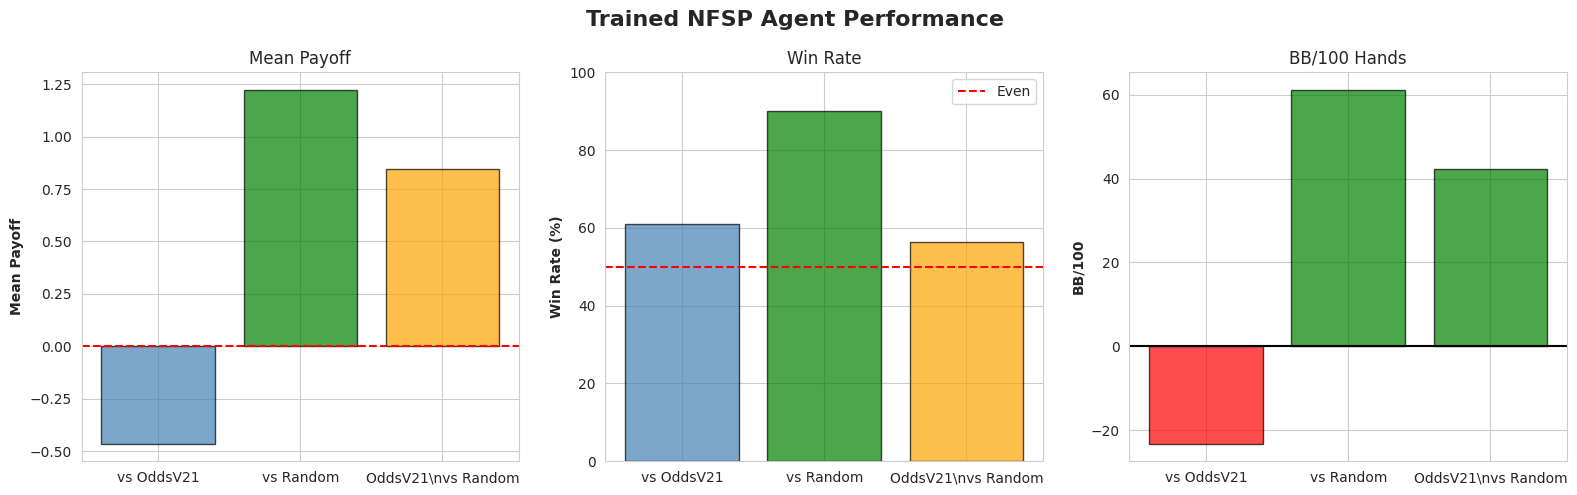

AttributeError: 'NFSPAgent' object has no attribute 'q_estimator'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import torch
from google.colab import files

sns.set_style("whitegrid")

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Trained NFSP Agent Performance', fontsize=16, fontweight='bold')

matchups = ['vs OddsV21', 'vs Random', 'OddsV21\\nvs Random']
means = [results['vs_odds']['mean'], results['vs_random']['mean'], results['odds_vs_random']['mean']]
win_rates = [results['vs_odds']['win_rate'], results['vs_random']['win_rate'], results['odds_vs_random']['win_rate']]
bb_100s = [results['vs_odds']['bb_100'], results['vs_random']['bb_100'], results['odds_vs_random']['bb_100']]

axes[0].bar(matchups, means, color=['steelblue','green','orange'], alpha=0.7, edgecolor='black')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_ylabel('Mean Payoff', fontweight='bold')
axes[0].set_title('Mean Payoff')

axes[1].bar(matchups, win_rates, color=['steelblue','green','orange'], alpha=0.7, edgecolor='black')
axes[1].axhline(50, color='red', linestyle='--', label='Even')
axes[1].set_ylabel('Win Rate (%)', fontweight='bold')
axes[1].set_title('Win Rate')
axes[1].set_ylim([0, 100])
axes[1].legend()

axes[2].bar(matchups, bb_100s, color=['green' if bb>0 else 'red' for bb in bb_100s], alpha=0.7, edgecolor='black')
axes[2].axhline(0, color='black', linestyle='-')
axes[2].set_ylabel('BB/100', fontweight='bold')
axes[2].set_title('BB/100 Hands')

plt.tight_layout()
plt.savefig('./experiments/colab_results/performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
torch.save({
    'q_net': agent.q_estimator.qnet.state_dict(),
    'policy_net': agent.policy_net.state_dict(),
    'episodes': EPOCHS,
    'final_performance': final_performance
}, './experiments/colab_results/trained_model.pth')

# Create zip
shutil.make_archive('/content/poker_results', 'zip', './experiments/colab_results/')

# Download
print("\\nDownloading results...")
files.download('/content/poker_results.zip')
print("✓ Download complete! Extract and use in your report.")